# **INTELIGENCIA DEL NEGOCIO / Business Intelligence**
## **ASSIGNMENT A3 - AUTOENCODERS**

**INSTRUCCIONES / RECOMENDACIONES**

- Se recomienda leer con detalle la descripción de cada una de las celdas.
- Las celdas que ya tienen código, se deberán ejecutar directamente.
- Las celdas que están vacías, se completarán con la implementación requerida en el notebook.
- No se incluirán más celdas de las establecidas en el presente notebook, por lo que la solución al mismo deberá implementarse exclusivamente en las celdas vacías.
- Scikit-Learn es un paquete muy útil para las operaciones de preprocesamiento de los datos, como estandarización, normalización, codificación, etc.
- Recuerda poner nombre a todas las layers de Keras, facilitará mucho las cosas a la hora de depurar errores.
- Si ves que un apartado es complejo, intenta escribir y ejecutarlo de forma simplificada (por ejemplo, con menos layers o con menos features) y después vaya amplíandolo.
- La entrega se realizará vía Moodle. Será necesario subir la solución a este notebook con el nombre: **NOMBRE_GRUPO.ipynb**

- **Fecha de Publicación: 11/03/2024**
- **Fecha de Entrega: 17/03/2024**
- **Test: 18/03/2024**
- **Autores: Luis Bueno y Yago Tobio**


In [1]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# * Data manipulation
import pandas as pd
import numpy as np
import os

# * Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# * Scikit learn
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, auc, precision_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
# * Keras
from keras import layers
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras import regularizers

# Carga de datos

Vamos a usar los autoencoders para tratar de predecir si un pago con una tarjeta es un pago fraudulento. Para ello, usaremos un dataset de datos reales en el que por cuestiones de confidencialidad se han aplicado transformaciones a los campos. En concreto, se han tomado 29 características y se les ha aplicado un PCA. De esta forma, no es posible saber cuál es el significado de cada una de ellas.

La columna Class del dataset indica si es un pago fradulento (1) o si no lo es (0).

El dataset se puede descargar desde el siguiente enlace: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pd_data = pd.read_csv("/content/drive/MyDrive/data/creditcard.csv").drop(columns=["Time"])
# - pd_data = pd.read_csv("creditcard.csv").drop(columns=['Time'])
pd_data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# Exploratorio
Realice un exploratorio simple de las features. Céntrese en la columna "Amount" que no ha sido tranformada y el target de la columna "Class".

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

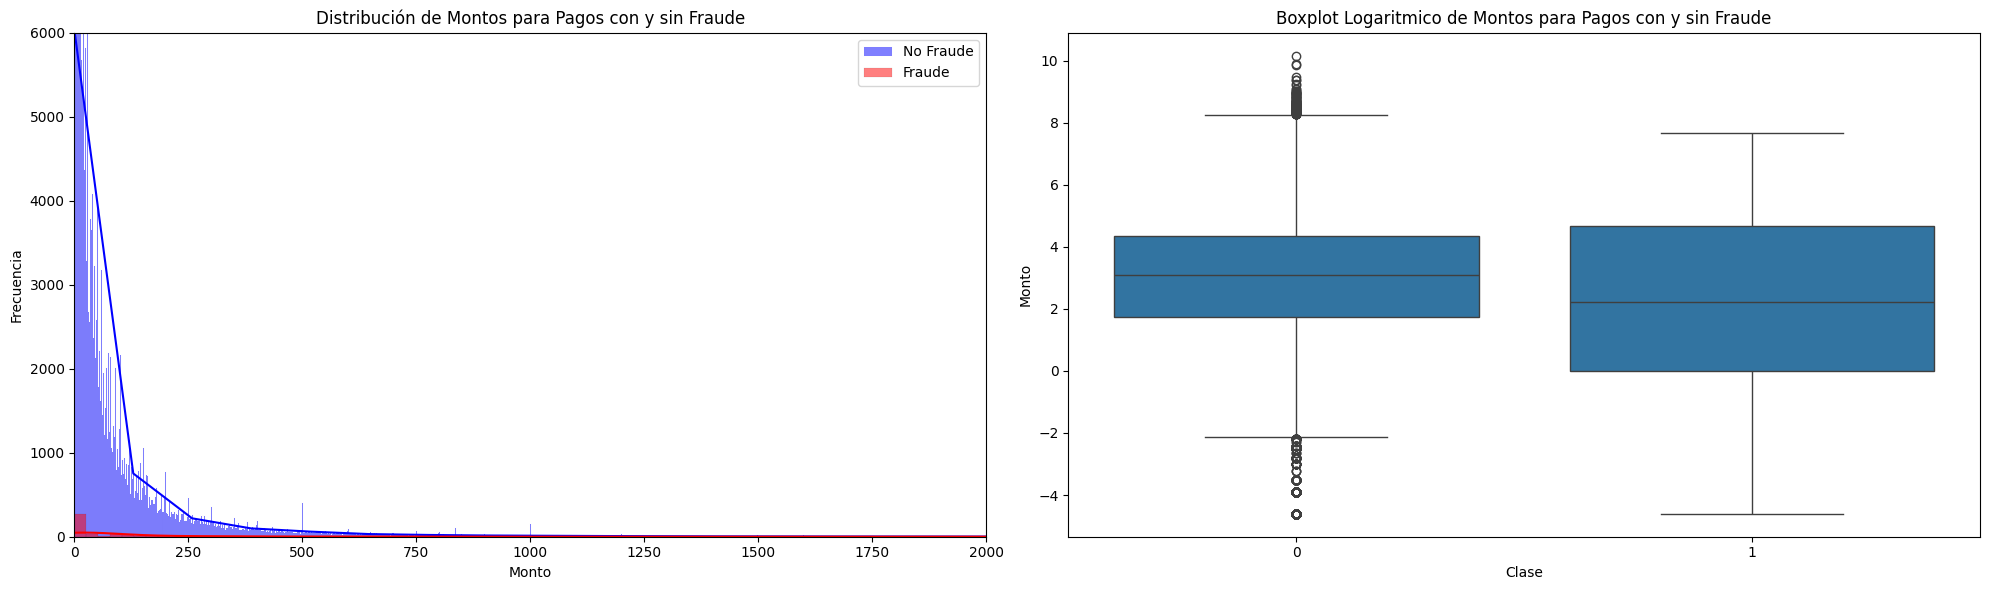

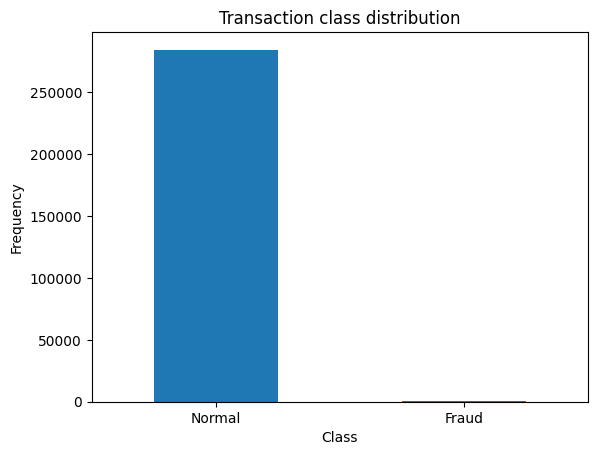

In [4]:
print(f"Dataset information: {pd_data.info()}\n\n")
print(f"Dataset description:{pd_data.describe()}\n\n")
print(f"Dataset Null Values? {pd_data.isnull().values.any()}\n\n")
 # * Estadísticas descriptivas para la columna "Amount"
print(pd_data['Amount'].describe())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# * Histograma para la distribución de "Amount" por clase
sns.histplot(pd_data[pd_data['Class'] == 0]['Amount'], ax=axes[0], color='blue', kde=True, label='No Fraude')
sns.histplot(pd_data[pd_data['Class'] == 1]['Amount'], ax=axes[0], color='red', kde=True, label='Fraude')
max_frequency = 6000
axes[0].set_ylim(0, max_frequency)
axes[0].set_xlim(0, 2000)
axes[0].set_title('Distribución de Montos para Pagos con y sin Fraude')
axes[0].set_xlabel('Monto')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

# * Boxplot con escala logaritmica para la distribución de "Amount" por clase
amount_log = np.log(pd_data['Amount'] + 0.01) # * Para no hacer el log de 0
amount_log.name = 'Amount_log'
df_log_boxplot = pd.concat([pd_data, amount_log], axis = 1)
sns.boxplot(df_log_boxplot, x='Class', y='Amount_log', ax=axes[1])
axes[1].set_title('Boxplot Logaritmico de Montos para Pagos con y sin Fraude')
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Monto')

# Mostrar la figura con ambos subplots
plt.tight_layout()  # Ajusta automáticamente los subplots para que encajen en la figura
plt.show()

count_classes = pd.value_counts(pd_data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), ["Normal", "Fraud"])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

# Preprocesado

Aplique una normalización para que las features estén en el intervalo 0 a 1. Además, divida el dataset en train y test.

In [5]:
 # ! - Definimos el scaler apropiado para que los valores no salgan del rango definido
scaler = MinMaxScaler(feature_range=(0,1))
pd_data_pr = pd_data.copy()
# * Scale all features except for the class
pd_data_pr.iloc[:, :-1] = scaler.fit_transform(pd_data_pr.iloc[:, :-1]) # * Al no incluir la variable del tiempo, normalizamos todo salvo la clase

X = pd_data_pr.drop('Class', axis = 1)
y = pd_data_pr['Class']

# Dividimos el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimimos las primeras filas del conjunto de entrenamiento para verificar
print(X_train[:5])


              V1        V2        V3        V4        V5        V6        V7  \
223361  0.991508  0.763241  0.831955  0.266566  0.762287  0.262153  0.261530   
165061  0.951482  0.760643  0.864365  0.162484  0.764991  0.264712  0.265465   
238186  0.959526  0.775917  0.827686  0.220461  0.772990  0.259406  0.270155   
150562  0.949204  0.777964  0.867750  0.374695  0.769083  0.273097  0.270521   
138452  0.889881  0.787278  0.829966  0.250619  0.759955  0.258190  0.262702   

              V8        V9       V10  ...       V20       V21       V22  \
223361  0.785772  0.499108  0.508092  ...  0.578930  0.565319  0.555202   
165061  0.781077  0.464171  0.521366  ...  0.575257  0.559005  0.529703   
238186  0.786643  0.458258  0.495517  ...  0.580396  0.556407  0.469307   
150562  0.784513  0.475580  0.520320  ...  0.577563  0.562504  0.530717   
138452  0.799478  0.481246  0.533999  ...  0.580134  0.553731  0.499284   

             V23       V24       V25       V26       V27       V28  

In [6]:
 # * Copiamos el dataset original para manipularlo
genuine_trx = pd_data_pr[pd_data_pr['Class'] == 0]
fraud_trx = pd_data_pr[pd_data_pr['Class'] == 1]
print(f"Features - Frauds: {fraud_trx.shape} - Genuine: {genuine_trx.shape}")

Features - Frauds: (492, 30) - Genuine: (284315, 30)


# Auto encoder

Se requiere construir un mecanismo para la detección de anomalías con un autoencoder. Vamos a considerar que los pagos fraudulentos son poco comunes y tienen algunas características especiales que no tienen el resto de pagos.

## Creación del modelo

Cree un autoencoder con encoder y decoder simétricos. Dos capas en cada uno serán suficientes, y tome como dimensión del Latent un valor entre 4 y 10.

Atención a la función de activación de la última capa del decoder!!!

In [7]:
 # * Definimos la dimensión de nuestras entradas y del espacio latente
input_dim = X_train.shape[1]  # * Número de características
latent_dim = 8  # * Dimensión del espacio latente
dropout_rate = 0.2

In [8]:
# ! - Definición del auto-encoder
# * Definimos el encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='tanh')(input_layer)
encoded = Dropout(dropout_rate)(encoded)
encoded = Dense(latent_dim, activation='relu')(encoded)

# * Definimos el decoder
decoded = Dense(16, activation='tanh')(encoded)
decoded = Dropout(dropout_rate)(decoded)

# * Capa de salida:
output_layer = Dense(input_dim, activation='sigmoid')(decoded) # ? - usamos 'sigmoid' para asegurar que la salida esté en el rango [0, 1]

# * Creamos el modelo de autoencoder
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mean_absolute_error'])

In [9]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │           493 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,253 (4.89 KB)

 Trainable params: 1,253 (4.89 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

Entrene el modelo hasta alcanzar la convergencia necesaria para la detección de anomalías.

In [10]:
EPOCHS = 40
BATCH_SIZE = 32

In [11]:
# * We're only going to train the model for the cases where there has been no fraud, as to establish the fraud error threshold later on.
history = autoencoder.fit(X_train[y_train == 0], X_train[y_train == 0],
                          validation_split = 0.2,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          verbose = 1,
                          shuffle = True).history

Epoch 1/40
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 4s 603us/step - loss: 0.5988 - mean_absolute_error: 0.0417 - val_loss: 0.5900 - val_mean_absolute_error: 0.0200
Epoch 2/40
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 3s 585us/step - loss: 0.5901 - mean_absolute_error: 0.0201 - val_loss: 0.5890 - val_mean_absolute_error: 0.0150
Epoch 3/40
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 4s 675us/step - loss: 0.5893 - mean_absolute_error: 0.0175 - val_loss: 0.5887 - val_mean_absolute_error: 0.0139
Epoch 4/40
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 3s 593us/step - loss: 0.5891 - mean_absolute_error: 0.0168 - val_loss: 0.5887 - val_mean_absolute_error: 0.0137
Epoch 5/40
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 3s 598us/step - loss: 0.5891 - mean_absolute_error: 0.0167 - val_loss: 0.5886 - val_mean_absolute_error: 0.0136
Epoch 6/40
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 3s 561us/step - loss: 0.5891 - mean_absolute_error: 0.0166 - val_loss: 0.5886 - val_mean_absolute_error: 0.0135
Epoch 7/40
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 4s 694us/step - loss: 0.5891 - mea

## Análisis de error de reconstrucción
Calcule el error cuadrático medio entre cada una de las muestras del dataset de train y la reconstrucción pasando por el autoencoder. Dibuje el histograma del error en los pagos fraudulentos y en los normales por separado, y en una misma gráfica. Comente los resultados.

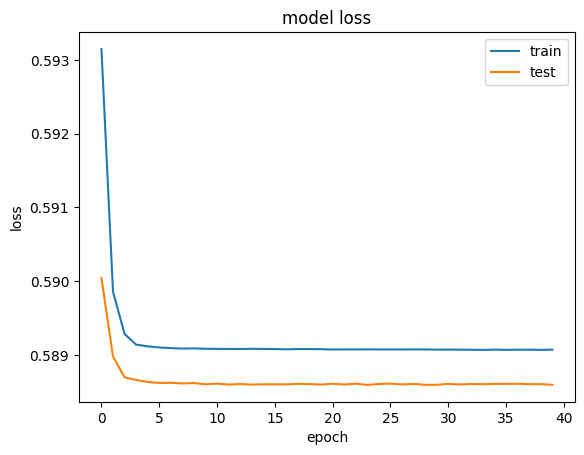

In [12]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [13]:
# Calculamos las reconstrucciones del conjunto de entrenamiento que esta vez contine ambos pagos genuinos y fraudulentos
X_train_pred = autoencoder.predict(X_train)

# Calculamos el error cuadrático medio para cada muestra
mse = np.mean(np.power(X_train - X_train_pred, 2), axis=1)

# Creamos un DataFrame para facilitar el análisis
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_train})
gen_error_df = error_df[error_df['true_class'] == 0]
fraud_error_df = error_df[error_df['true_class'] == 1]

7121/7121 ━━━━━━━━━━━━━━━━━━━━ 2s 262us/step


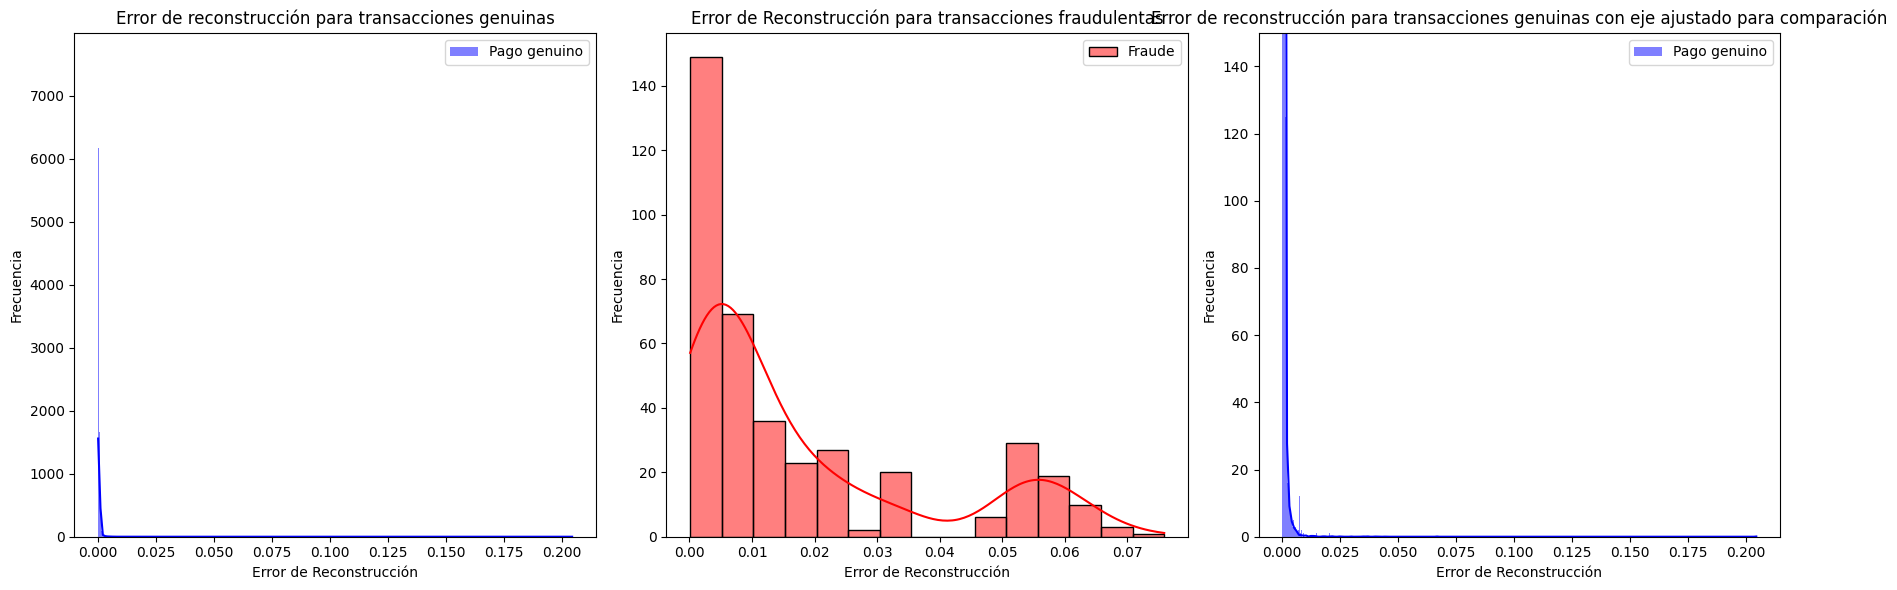

In [14]:
# Dibujamos el histograma del error en los pagos fraudulentos y en los normales por separado
plt.figure(figsize=(18, 6))

plt.subplot(1,3,1)
sns.histplot(gen_error_df['reconstruction_error'], color='blue', kde=True, label='Pago genuino')
plt.xlabel('Error de Reconstrucción')
plt.ylabel('Frecuencia')
plt.title('Error de reconstrucción para transacciones genuinas')
plt.legend()

plt.subplot(1,3,2)
sns.histplot(fraud_error_df['reconstruction_error'], color='red', kde=True, label='Fraude')
plt.title('Error de Reconstrucción para transacciones fraudulentas')
plt.xlabel('Error de Reconstrucción')
plt.ylabel('Frecuencia')
plt.legend()

plt.subplot(1,3,3)
sns.histplot(gen_error_df['reconstruction_error'], color='blue', kde=True, label='Pago genuino')
plt.xlabel('Error de Reconstrucción')
plt.ylabel('Frecuencia')
plt.ylim(0,150) # * Para poder comparar ambas distribuciones
plt.title('Error de reconstrucción para transacciones genuinas con eje ajustado para comparación')
plt.legend()

plt.tight_layout()
plt.show()

Podemos observar, que la frecuencia y magnitud de los errores de reconstrucción son mucho menores para los pagos genuinos, mientras que los fraudulentos son menos frecuentes, pero tienen un error mucho mayor de reconstrucción. Es decir, que hay mayor distribución de errores de reconstrucción más alto en casos de fraude.

Esto nos da una buena indicación que con un error mayor a 0.01, ya podríamos declarlo un posible pago fraudulento.

## Elección del threshold
Vamos a tratar de elegir un buen valor de threshold del error para decidir si es un pago fradulento o no lo es. Para ello, tome unos 100 valores en el rango que toma el threshold y calcule sobre el dataset de train la precisión, el recall, el false positive rate y el true positive rate. Pinte cada uno de ellos en una gráfica (el eje x es el posible valor del threshold).

**Nota de los autores:** Es importante destacar que Recall y el True Positive Rate son exactamente lo mismo. Por lo cual se ha decidido calcular el F-Score de manera adicional


In [15]:
def false_positive_rate(y, y_pred):
    """y is 0, y_pred is 1"""
    return sum( (1- y) * y_pred) / sum(1-y)
def true_positive_rate(y, y_pred):
    """both are one"""
    return sum(y * y_pred) / sum(y)

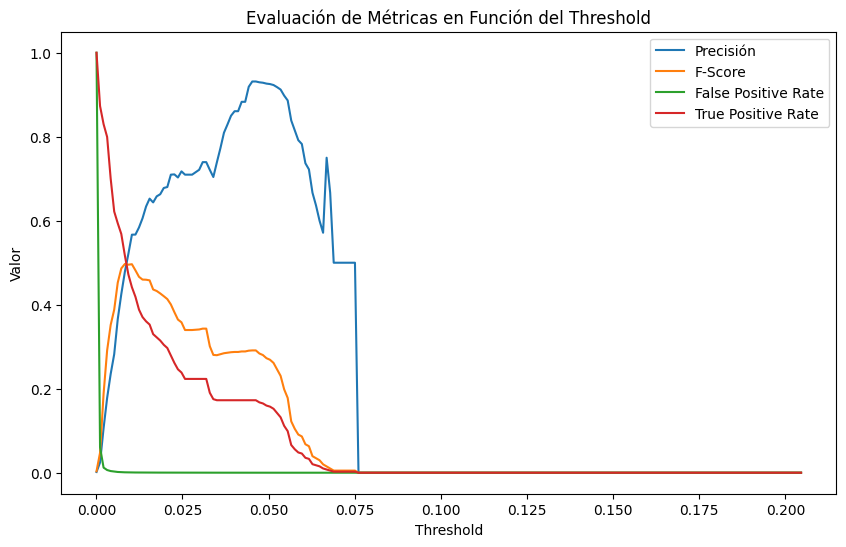

In [16]:
from sklearn.metrics import f1_score

threshold_values = np.linspace(min(mse), max(mse), 200) # * Check if we must also base ourselves on mse for the compilation of the model
precision_values, f1_values, fpr_values, tpr_values = [],[],[],[]

error_df = error_df.dropna(subset=['true_class'])

for threshold in threshold_values:
    # Etiquetamos las predicciones basadas en el threshold
    predictions = (error_df['reconstruction_error'] > threshold).astype(int)

    # Calculamos métricas
    precision = precision_score(error_df['true_class'], predictions)
    recall = recall_score(error_df['true_class'], predictions)

    tn, fp, fn, tp = confusion_matrix(error_df['true_class'], predictions).ravel()
    fpr = false_positive_rate(error_df['true_class'], predictions)
    tpr = true_positive_rate(error_df['true_class'], predictions)
    f1 = f1_score(error_df['true_class'], predictions)

    # Almacenamos los valores de las métricas
    precision_values.append(precision)
    f1_values.append(f1)
    fpr_values.append(fpr)
    tpr_values.append(tpr)

# Dibujamos las métricas en función del threshold
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, precision_values, label='Precisión')
plt.plot(threshold_values, f1_values, label='F-Score')
plt.plot(threshold_values, fpr_values, label='False Positive Rate')
plt.plot(threshold_values, tpr_values, label='True Positive Rate')
plt.title('Evaluación de Métricas en Función del Threshold')
plt.xlim(0,0.150)
plt.xlabel('Threshold')
plt.ylabel('Valor')
plt.legend()
plt.show()

## Evaluación en test
Tomando un valor del threshold que considere adecuado, calcule la precisión, el recall, el false positive rate y el true positive rate sobre el dataset de test.

**Comentarios de los autores:**
Hemos elegido obtener el valor de umbral en el que la puntuación F1 es óptima, ya que buscamos un equilibrio entre la precisión y el recuento de nuestro modelo de detección de anomalías. La puntuación F1 es una medida que combina la precisión (la proporción de anomalías correctamente identificadas entre todas las detectadas por el modelo) y el recuento (la proporción de anomalías correctamente identificadas entre todas las anomalías reales en el conjunto de datos).

In [17]:
max_f1_index = np.argmax(f1_values)
optimal_threshold = threshold_values[max_f1_index]

print(f'Optimal threshold based on F1 score: {optimal_threshold}')

Optimal threshold based on F1 score: 0.008268448407241944


In [18]:
# Etiquetar las predicciones en el conjunto de prueba basado en el threshold elegido
X_test_pred = autoencoder.predict(X_test)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
predictions_test = (mse_test > optimal_threshold).astype(int)

# Calcular métricas en el conjunto de prueba
precision_test = precision_score(y_test, predictions_test)
recall_test = recall_score(y_test, predictions_test)

tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, predictions_test).ravel()
fpr_test = fp_test / (fp_test + tn_test)
tpr_test = tp_test / (tp_test + fn_test)

# Mostrar las métricas en el conjunto de prueba
print(f'Precisión en el theshold optimo: {precision_test:.4f}')
print(f'Recall en el conjunto de prueba: {recall_test:.4f}')
print(f'False Positive Rate en el conjunto de prueba: {fpr_test:.4f}')
print(f'F1-Score en el threshold optimo: {max_f1_index:.4f}')

   1/1781 ━━━━━━━━━━━━━━━━━━━━ 58s 33ms/step

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 342us/step
Precisión en el theshold optimo: 0.4608
Recall en el conjunto de prueba: 0.4796
False Positive Rate en el conjunto de prueba: 0.0010
F1-Score en el threshold optimo: 8.0000


Text(0.5, 1.0, 'Precision-Recall Curve - AUC:0.45')

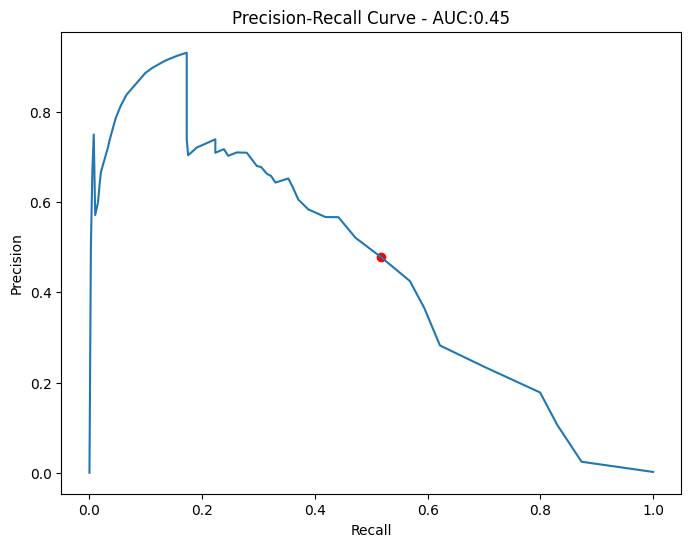

In [19]:
auc_pr = auc(tpr_values, precision_values)

plt.figure(figsize=(8,6))
plt.plot(tpr_values,precision_values, label='Precision-Recall Curve')
plt.scatter(tpr_values[max_f1_index], precision_values[max_f1_index], color='red', label=f'Optimal Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - AUC:{auc_pr:.2f}')

# Sparse AutoEncoder

## Creación del modelo
Repitamos todo el proceso pero usando un sparse autoencoder. Solamente añada regularización l1 en la última capa del encoder. Además, puede probar a aumentar un poco la dimensión del encoding.

In [20]:
L1_REG = 1e-5

# ! - Definición del sparse auto-encoder
input_layer_sparse = Input(shape=(input_dim,))
encoded = Dense(16, activation='tanh', activity_regularizer=regularizers.l1(L1_REG))(input_layer_sparse)
encoded = Dropout(dropout_rate)(encoded)
encoded = Dense(latent_dim, activation='relu', activity_regularizer=regularizers.l1(L1_REG))(encoded)

# * Definimos el decoder
decoded = Dense(16, activation='tanh')(encoded)
decoded = Dropout(dropout_rate)(decoded)

# * Capa de salida:
output_layer_sparse = Dense(input_dim, activation='sigmoid')(decoded) # ? - usamos 'sigmoid' para asegurar que la salida esté en el rango [0, 1]

# * Creamos el modelo de autoencoder
sparse_autoencoder = Model(input_layer_sparse, output_layer_sparse)
sparse_autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

## Entrenamiento

In [21]:
sparse_history = sparse_autoencoder.fit(X_train[y_train == 0], X_train[y_train == 0],  # target data is the same as input data
                          validation_split=0.2,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          verbose=1,  # Set to 1 or 2 to see the training progress
                          shuffle=True)  # Shuffling the data is generally a good idea for training

Epoch 1/40
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 5s 772us/step - loss: 0.6004 - mse: 0.0046 - val_loss: 0.5904 - val_mse: 0.0011
Epoch 2/40
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 5s 796us/step - loss: 0.5906 - mse: 0.0012 - val_loss: 0.5901 - val_mse: 0.0010
Epoch 3/40
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 4s 691us/step - loss: 0.5903 - mse: 0.0011 - val_loss: 0.5897 - val_mse: 8.9343e-04
Epoch 4/40
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 4s 754us/step - loss: 0.5900 - mse: 9.9780e-04 - val_loss: 0.5896 - val_mse: 8.4565e-04
Epoch 5/40
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 4s 620us/step - loss: 0.5898 - mse: 9.4290e-04 - val_loss: 0.5894 - val_mse: 7.5201e-04
Epoch 6/40
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 4s 623us/step - loss: 0.5897 - mse: 8.7082e-04 - val_loss: 0.5894 - val_mse: 7.3115e-04
Epoch 7/40
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 4s 696us/step - loss: 0.5896 - mse: 8.5988e-04 - val_loss: 0.5893 - val_mse: 7.2915e-04
Epoch 8/40
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 4s 711us/step - loss: 0.5896 - mse: 8.5719e-04 - val_loss: 0.5893 - 

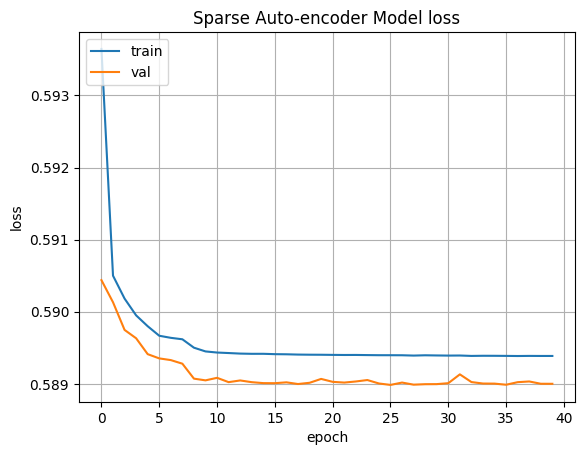

In [24]:
plt.plot(sparse_history.history['loss'])
plt.plot(sparse_history.history['val_loss'])
plt.title('Sparse Auto-encoder Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()

## Análisis de error de reconstrucción
Calcule el error cuadrático medio entre cada una de las muestras del dataset de train y la reconstrucción pasando por el autoencoder. Dibuje el histograma del error en los pagos fraudulentos y en los normales por separado en una misma gráfica. Comente los resultados.

In [22]:
# Predict the reconstruction of the training data
prediction_sparse = sparse_autoencoder.predict(X_train)
mse_sparse = np.mean(np.power(X_train - prediction_sparse, 2), axis=1)
sparse_error_df = pd.DataFrame({'reconstruction_error': mse,
                                        'true_class': y_train})

7121/7121 ━━━━━━━━━━━━━━━━━━━━ 2s 322us/step


In [28]:
# Separate the errors by class
gen_error_df = sparse_error_df[sparse_error_df['true_class'] == 0]
fraud_error_df = sparse_error_df[sparse_error_df['true_class'] == 1]

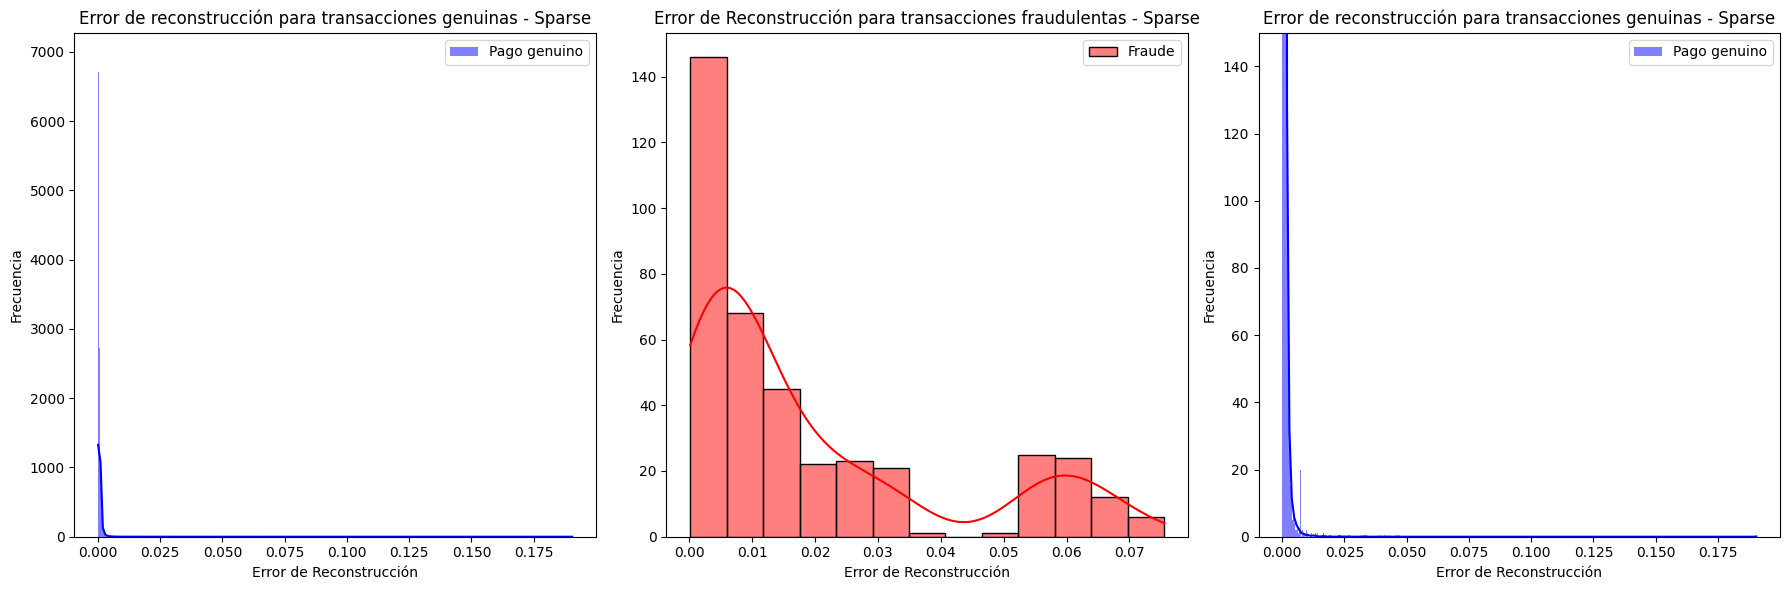

In [30]:
# Dibujamos el histograma del error en los pagos fraudulentos y en los normales por separado
plt.figure(figsize=(18, 6))

plt.subplot(1,3,1)
sns.histplot(gen_error_df['reconstruction_error'], color='blue', kde=True, label='Pago genuino')
plt.xlabel('Error de Reconstrucción')
plt.ylabel('Frecuencia')
plt.title('Error de reconstrucción para transacciones genuinas - Sparse')
plt.legend()

plt.subplot(1,3,2)
sns.histplot(fraud_error_df['reconstruction_error'], color='red', kde=True, label='Fraude')
plt.title('Error de Reconstrucción para transacciones fraudulentas - Sparse')
plt.xlabel('Error de Reconstrucción')
plt.ylabel('Frecuencia')
plt.legend()

plt.subplot(1,3,3)
sns.histplot(gen_error_df['reconstruction_error'], color='blue', kde=True, label='Pago genuino')
plt.xlabel('Error de Reconstrucción')
plt.ylabel('Frecuencia')
plt.ylim(0,150) # * Para poder comparar ambas distribuciones
plt.title('Error de reconstrucción para transacciones genuinas - Sparse')
plt.legend()

plt.tight_layout()
plt.show()

## Elección del threshold
Calcule las mismas métricas de antes en función del threshold. Pinte en la misma gráfica la curva del autoencoder y la del sparse autoencoder. ¿Cuál funciona mejor?

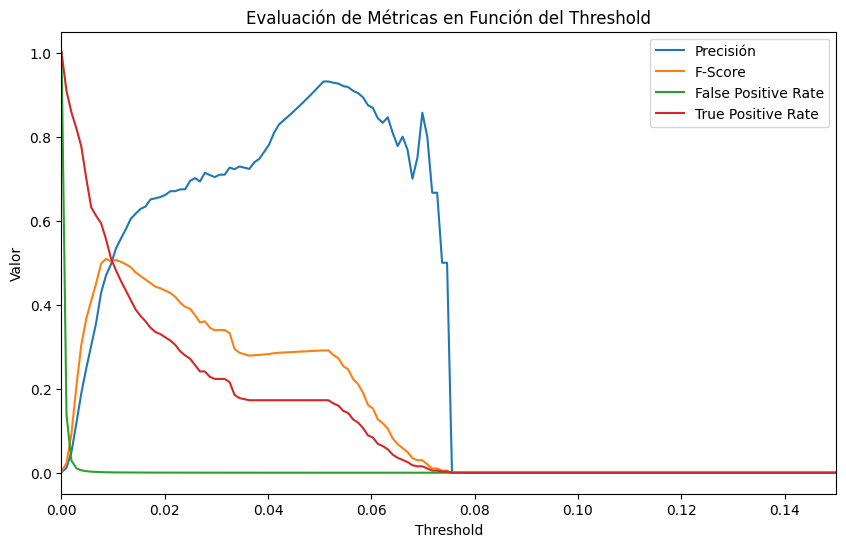

In [33]:
from sklearn.metrics import f1_score

threshold_values_sparse = np.linspace(min(mse_sparse), max(mse_sparse), 200) # * Check if we must also base ourselves on mse for the compilation of the model
precision_values_sparse, f1_values_sparse, fpr_values_sparse, tpr_values_sparse = [],[],[],[]

sparse_error_df = sparse_error_df.dropna(subset=['true_class'])

for threshold in threshold_values_sparse:
    # Etiquetamos las predicciones basadas en el threshold
    predictions = (sparse_error_df['reconstruction_error'] > threshold).astype(int)

    # Calculamos métricas
    precision = precision_score(sparse_error_df['true_class'], predictions)
    recall = recall_score(sparse_error_df['true_class'], predictions)

    tn, fp, fn, tp = confusion_matrix(sparse_error_df['true_class'], predictions).ravel()
    fpr = false_positive_rate(sparse_error_df['true_class'], predictions)
    tpr = true_positive_rate(sparse_error_df['true_class'], predictions)
    f1 = f1_score(sparse_error_df['true_class'], predictions)

    # Almacenamos los valores de las métricas
    precision_values_sparse.append(precision)
    f1_values_sparse.append(f1)
    fpr_values_sparse.append(fpr)
    tpr_values_sparse.append(tpr)

# Dibujamos las métricas en función del threshold
plt.figure(figsize=(10, 6))
plt.plot(threshold_values_sparse, precision_values_sparse, label='Precisión')
plt.plot(threshold_values_sparse, f1_values_sparse, label='F-Score')
plt.plot(threshold_values_sparse, fpr_values_sparse, label='False Positive Rate')
plt.plot(threshold_values_sparse, tpr_values_sparse, label='True Positive Rate')
plt.title('Evaluación de Métricas en Función del Threshold')
plt.xlim(0,0.150)
plt.xlabel('Threshold')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [34]:
max_f1 = np.argmax(f1_values_sparse)
optimal_threshold = threshold_values_sparse[max_f1]

print(f'Optimal threshold based on F1 score: {optimal_threshold}')

Optimal threshold based on F1 score: 0.008663992655669332


Observamos que el valor para el threshold es mucho menor, lo cual nos indicaría en teoría que la barrera para sospechar de un pago como fraudulento, esta mucho más baja, lo cual implica un mejor modelo. 

## Evaluación en test
Tomando un valor del threshold que considere adecuado, calcule la precisión, el recall, el false positive rate y el true positive rate sobre el dataset de test.

Text(0.5, 1.0, 'Precision-Recall Curve - AUC:0.46')

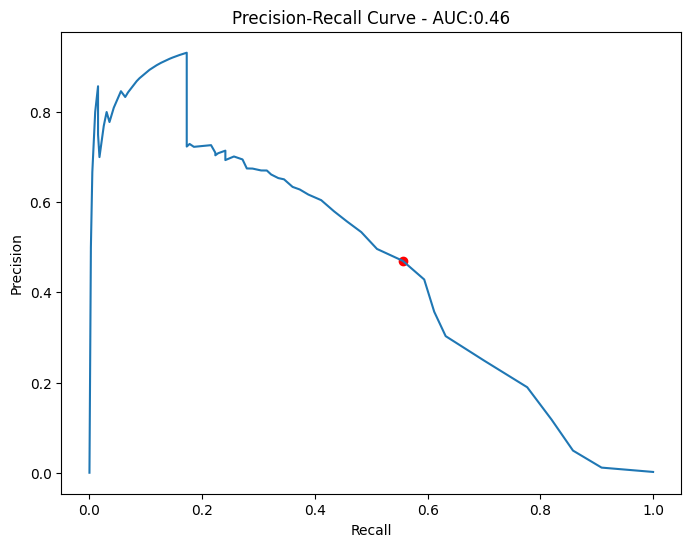

In [35]:
auc_pr = auc(tpr_values_sparse, precision_values_sparse)

plt.figure(figsize=(8,6))
plt.plot(tpr_values_sparse,precision_values_sparse, label='Precision-Recall Curve')
plt.scatter(tpr_values_sparse[max_f1], precision_values_sparse[max_f1], color='red', label=f'Optimal Threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - AUC:{auc_pr:.2f}')

In [37]:
# Etiquetar las predicciones en el conjunto de prueba basado en el threshold elegido
X_test_pred = sparse_autoencoder.predict(X_test)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
predictions_test = (mse_test > optimal_threshold).astype(int)

# Calcular métricas en el conjunto de prueba
precision_test = precision_score(y_test, predictions_test)
recall_test = recall_score(y_test, predictions_test)

tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, predictions_test).ravel()
fpr_test = fp_test / (fp_test + tn_test)
tpr_test = tp_test / (tp_test + fn_test)

# Mostrar las métricas en el conjunto de prueba
print(f'Precisión en el theshold optimo: {precision_test:.4f}')
print(f'Recall en el conjunto de prueba: {recall_test:.4f}')
print(f'False Positive Rate en el conjunto de prueba: {fpr_test:.4f}')
print(f'F1-Score en el threshold optimo: {max_f1_index:.4f}')

   1/1781 ━━━━━━━━━━━━━━━━━━━━ 1:00 34ms/step

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step
Precisión en el theshold optimo: 0.4495
Recall en el conjunto de prueba: 0.5000
False Positive Rate en el conjunto de prueba: 0.0011
F1-Score en el threshold optimo: 9.0000


# Elección del threshold en base a un Caso de Uso
En este apartado tome la versión del autoencoder que haya dado mejores resultados.

Planteemos el siguiente Caso de Uso:

Cuando detectamos que un pago puede ser fraudulento, podemos hacer una llamada al cliente para que confirme que ha sido él quien ha realizado el pago; en este caso estimamos el coste de la llamada en 50 céntimos.
También podemos confiar en que el cliente posteriormente nos llame para notificar el fraude y cancelar el pago; en este caso, se realiza una gestión más cara que estimamos en unos 2 euros.

¿Cuál debería ser el threshold para minimizar el coste? Explique el razonamiento.

**Respuesta:**
Para poder minimizar el coste, debemos de generar una función de optimización para equilibrar los costes de intervención y de pasividad, teniendo en cuenta la precisión y el recall del modelo de detección (por el auto-encoder).
* El coste de llamar innecesariamente a los clientes se asocia con los falsos positivos. False Positive Rate $\times$ Cost Call
* El coste de gestionar la reclamación, sería asociado con los falsos negativos. False Negative Rate $\times$ Cancellation Cost

Es decir:

$C_{total} = (C_{FP} \times FPR) + (C_{FN} \times FNR)$

Lo que tenemos que hacer ahora es variar el umbral y minimizar el resultado.

In [39]:
COST_CALL = 0.5
COST_CANCELLATION = 2

In [44]:
def prediction_cost(y, y_pred):
    """Calculates the cost of each prediction"""
    if (y_pred == 1):# false negative
      value =  COST_CALL
    elif (y == 1 and y_pred == 0):
      value = COST_CANCELLATION
    else:
      value = 0
    return value

def model_cost(y, y_pred):
    costs = np.vectorize(prediction_cost)(y, y_pred)
    return np.sum(costs)

In [45]:
reconstruction = sparse_autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - reconstruction, 2), axis=1)
mse_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_train})

# Metrics to store
prediction_costs, f1s = [], []
# Threshold range to check
thresholds = np.linspace(mse_df['reconstruction_error'].min(), mse_df['reconstruction_error'].max(), 100)

for threshold in thresholds:
    y_pred = (mse_df['reconstruction_error'] > threshold).astype(int)

    # Calculate prediction cost and f1 score
    cost = model_cost(mse_df['true_class'], y_pred)
    f1 = f1_score(mse_df['true_class'], y_pred)

    # Append the metrics to the lists
    prediction_costs.append(cost)
    f1s.append(f1)

   1/7121 ━━━━━━━━━━━━━━━━━━━━ 1:26 12ms/step

7121/7121 ━━━━━━━━━━━━━━━━━━━━ 2s 318us/step


In [46]:
# Find the threshold that minimizes the cost
min_index = np.argmin(prediction_costs)
optimal_threshold = thresholds[min_index]

print(f"Optimal Threshold based on prediction costs: {optimal_threshold}")
print(f"Minimum prediction cost: {np.min(prediction_costs)}")

Optimal Threshold based on prediction costs: 0.001977668499823178
Minimum prediction cost: 112.0


<Figure size 800x600 with 0 Axes>

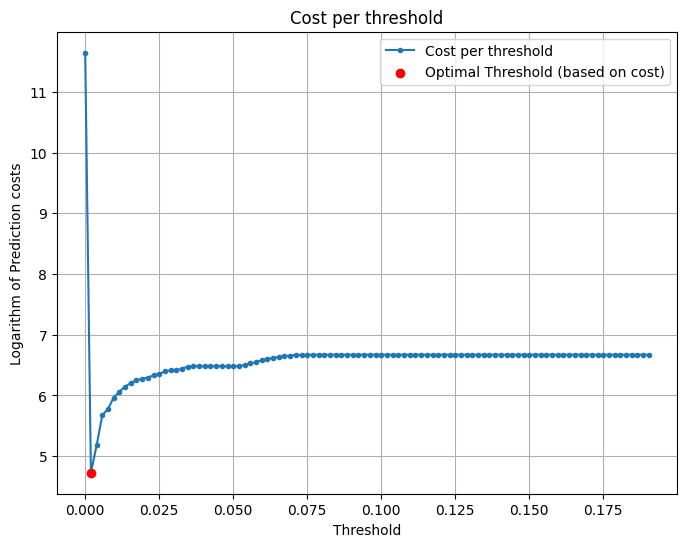

In [47]:
plt.figure(figsize=(8, 6))
# Transforming prediction_costs to a logarithmic scale
log_prediction_costs = np.log1p(prediction_costs)

# Plotting a curve between cost and threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, log_prediction_costs, marker='.', label='Cost per threshold')
plt.scatter(thresholds[min_index], log_prediction_costs[min_index], color='red', label=f'Optimal Threshold (based on cost)', zorder=5)  # Highlight the optimal point
plt.xlabel('Threshold')
plt.ylabel('Logarithm of Prediction costs')
plt.title('Cost per threshold')
plt.legend()
plt.grid(True)
plt.show()

# Conclusiones del estudio

Detallar las principales conclusiones extraidas sobre la construcción del modelo Autoencoder, la comparativa entre modelos y su aplicación en sistemas de detección de anomalías.

**Conclusiones de los autores:**
En esta práctica se ha explorado la construcción y optimización de modelos de autoencoders y la incorporación de sus parametros sparse. Estos módelos sirven para hallar representaciones de datos en vectores latentes de dimensión reducida. Hacer un autoencoder sparse sirve para restringir de manera adicional la red neuronal, con el objetivo que se haya mayor enfasis sobre los patrones de los datos. Lo cual resulta extremadamente útil para la detección de anomalías como los pagos fraudulentos. 

Al haber entrenado el autoencoder únicamente sobre los pagos genuinos, esto facilitó la clasificación de anomalías. Como threshold usamos el F1 Score, ya que ofrece un equilibrio entre las metricas de precision & recall. Pero puede ser que en un caso real se priorizase otra metrica como la precisión o la exactitud. 

Conclusión de los resultados: 

1. Autoencoder normal:
* Precisión en el theshold optimo: 0.4608
* Recall en el conjunto de prueba: 0.4796
* False Positive Rate en el conjunto de prueba: 0.0010
* F1-Score en el threshold optimo: 8.0000
* AUC: 0.45

2. Sparse Autoencoder: 
* Precisión en el theshold optimo: 0.4495
* Recall en el conjunto de prueba: 0.5000
* False Positive Rate en el conjunto de prueba: 0.0011
* F1-Score en el threshold optimo: 9.0000
* AUC: 0.46

*En terminos del ejercicio práctico, decidimos hacer uso del Sparse Autoencoder en base al resultado ligeramente mejor del AUC y su mejor F1-Score, y obtuvimos un módelo con coste de 112 euros, con un threshold optimo de 0.00866399265566933.*